In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from PortfolioToolboxQP.PortfolioToolboxQP.Qp_Solver import qp_solver_cpp as solve

Il faut remplir le code suivant avec ce qu'on a calculé dans les autres fichiers. Faut juste faire attention à ce qu'on est les mêmes colonnes pour tous sinon on va avoir des problèmes de dimensions.

In [4]:
sigma = np.load("data/cov_matrix_sigma.npy")
CI = pd.read_csv("data/CarbonIntensity.csv")
CI0 = CI["CI_Scope12_FY23"].values.reshape(-1, 1)
bench = (CI["Weight"].values / CI["Weight"].sum()).reshape(-1, 1)


J'ai pris le problème le plus simple avec le moins de contrainte (min 1/2(x-b)Tsigma(x-b) avec comme contraintes la carbone intensity, et le bail C0 des long only constraints [x entre 0 et 1 et qui se somme à 1])

x is what we want : here the relative weights on the differents firms. The following Y is what we call "x-b". 
 We have to add the benchmark at the end

                            minimize 0.5*Y.T@Q@Y + p@Y under constraints AY = B and GY <= h and  lb <= Y <= ub
    
    all parameters are ndarray

    Q: sigma for us
    p: 0

    CI*(X=Y+b) <= (1-R)CI_0*b donc CI*Y <= (1-R)*CI_0*b - CI*b
    G: Matrix of inequalty constraints → np.diag(CI0[:,0])
    h: Vector of inequality constraints → (1 - R) * CI0*bench - CI0*bench

    1.T(Y+b)=1 donc 1TY = - 1Tb + 1
    A: Matrix of equality constraints → 1T
    b: Vector of equality constraints → -1Tb + 1
    
    lb: Lower bound for Y : for x : 0
    ub: Upper bound for Y : for x : 1

    return: optimal vector if found : Y=X-b

Calcul du Reduction Rate

In [5]:
def decarbonization_pathway(t0, t, Rm, dR):
    """
    Compute the decarbonization budget with equation (1).

    param t0: base year
    param t: year index
    param Rm: minimum carbon intensity reduction
    param dR: year-to-year self decarbonization on average per annum
    """
    return 1 - (1 - dR) ** (t - t0) * (1 - Rm)

In [6]:
t0, t = 2023, 2050

times = np.arange(t0, t + 1)

# CTB label: Rm=0.3 dR=0.07
ctb_label = decarbonization_pathway(t0, times, 0.3, 0.07)

# PAB label: Rm=0.5 dr=0.07
pab_label = decarbonization_pathway(t0, times, 0.5, 0.07)

x_list = []
te = []
R_ = ctb_label

for year in range(5):
    R = R_[year]
    ye = 23+year
    print(ye)
    column = "CI_Scope12_FY"+str(ye)
    CI_year = CI[column].values.reshape(-1, 1)
    CI_year[CI_year < 0] = 0 # pb de carbon intensity négatives qui empechent l'algo de converger quand on met les valeurs négatives à 0 ça tourne
    y = solve(
        Q = sigma,
        p = None,
        G = np.diag(CI_year[:,0]),
        h = (1 - R) * CI0 * bench - CI_year * bench,
        A = np.ones((bench.shape[0],1)).T,
        b =-np.ones(bench.shape).T @ bench + 1,
        lb = - bench,
        ub =np.ones(bench.shape) - bench,
    )
    y = y[:,np.newaxis]
    x = y + bench
    x_list.append(x)
    name_col = "Weight_FY"+str(ye)
    CI[name_col] = x
    print(x.sum())
    tracking_error = 0.5 * y.T @ sigma @ y
    te.append(tracking_error)



23


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


1.0
24


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


1.0
25


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


1.0
26


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


1.0
27


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


1.0


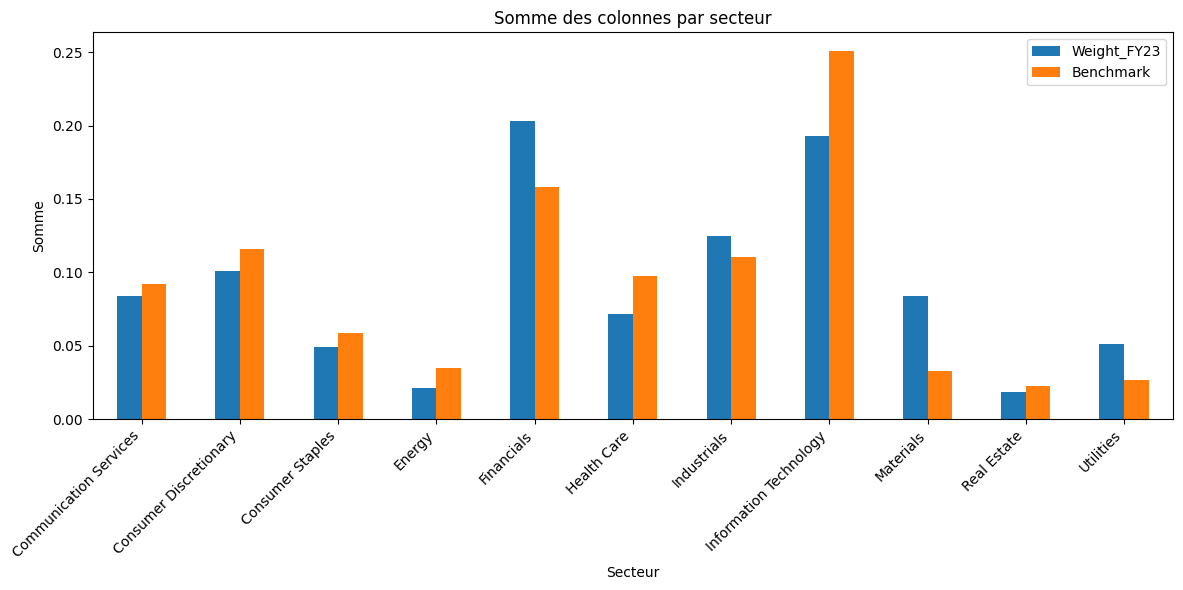

In [19]:
CI["benchmark"] = bench
grouped = CI.groupby("GICS_SECTOR")[["Weight_FY25", "benchmark"]].sum()

# Tracer l'histogramme
grouped.plot(
    kind="bar",
    figsize=(12, 6),
    stacked=False,  # Changez en True pour un histogramme empilé
)
plt.title("Somme des colonnes par secteur")
plt.xlabel("Secteur")
plt.ylabel("Somme")
plt.xticks(rotation=45, ha="right")  # Rotation des étiquettes pour lisibilité
plt.legend(["Weight_FY23", "Benchmark"], loc="upper right")  # Légende personnalisée
plt.tight_layout()
plt.show()